In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
mat_contents = sio.loadmat('kos_doc_data.mat')

In [2]:
A = mat_contents['A'] # train
B = mat_contents['B'] # test
V = mat_contents['V'] # vocabulary list

In [3]:
print(A[:3,:])
print('Min ID of documents in A: '+str(A[:,0].min()))
print('Max ID of documents in A: '+str(A[:,0].max()))
print('No. of distinct words from A: '+str(A[:,1].max()))
print('No. of distinct word occurences in As doc: '+str(A[:,2].max()))

print('Min ID of documents in B: '+str(B[:,0].min()))
print('Max ID of documents in B: '+str(B[:,0].max()))
print('No. of distinct words from B: '+str(B[:,1].max()))
print('No. of distinct word occurences in Bs doc: '+str(B[:,2].max()))

print('No. of distinct words frBom V: '+str(len(V)))

[[ 1  2  1]
 [ 1 15  1]
 [ 1 28  1]]
Min ID of documents in A: 1
Max ID of documents in A: 2000
No. of distinct words from A: 6906
No. of distinct word occurences in As doc: 29
Min ID of documents in B: 2001
Max ID of documents in B: 3430
No. of distinct words from B: 6906
No. of distinct word occurences in Bs doc: 43
No. of distinct words frBom V: 6906


In [4]:
W = A[:,1].max(); D = A[:,0].max(); K = 20
alpha = 10; gamma = .1

In [5]:
sd = np.ceil(K*np.random.uniform(0,1,(D,1))).astype(int)
swk = np.zeros((W,K))
sk_docs = np.zeros((K,1))

for d in range(D):
    w = A[A[:,0]==d+1,1]-1
    c = A[A[:,0]==d+1,2]
    k = sd[d]-1
    swk[w,k] += c
    sk_docs[k] += 1
sk_words = np.sum(swk,axis=0)

In [6]:
def sampDiscrete(b):
    r = np.sum(b)*np.random.uniform(0,1,1)
    a = b[0,0]; i = 0
    while a < r:
        i+=1
        a+=b[0,i]
    return i+1

In [7]:
docs_mixpro = []
for itr in range(20):
    for d in range(D):
        w = A[A[:,0]==d+1,1]-1
        c = A[A[:,0]==d+1,2]
        swk[w,sd[d]-1] -= c
        sk_docs[sd[d]-1] -= 1
        sk_words[sd[d]-1] -= np.sum(c)
        lb = np.zeros((1,K))
        for k in range(K):
            ll=np.dot(c,np.log(swk[w,k]+gamma)-
                      np.log(sk_words[k]+gamma*W))
            lb[0,k] = np.log(sk_docs[k]+alpha)+ll
        b = np.exp(lb-lb.max())
        kk = sampDiscrete(b)
        swk[w,kk-1] += c
        sk_docs[kk-1] += 1
        sk_words[kk-1] += np.sum(c)
        sd[d] = kk
    if itr == 0:
        docs_mixpro = sk_docs/2000
    else:
        docs_mixpro = np.hstack((docs_mixpro,sk_docs/2000))

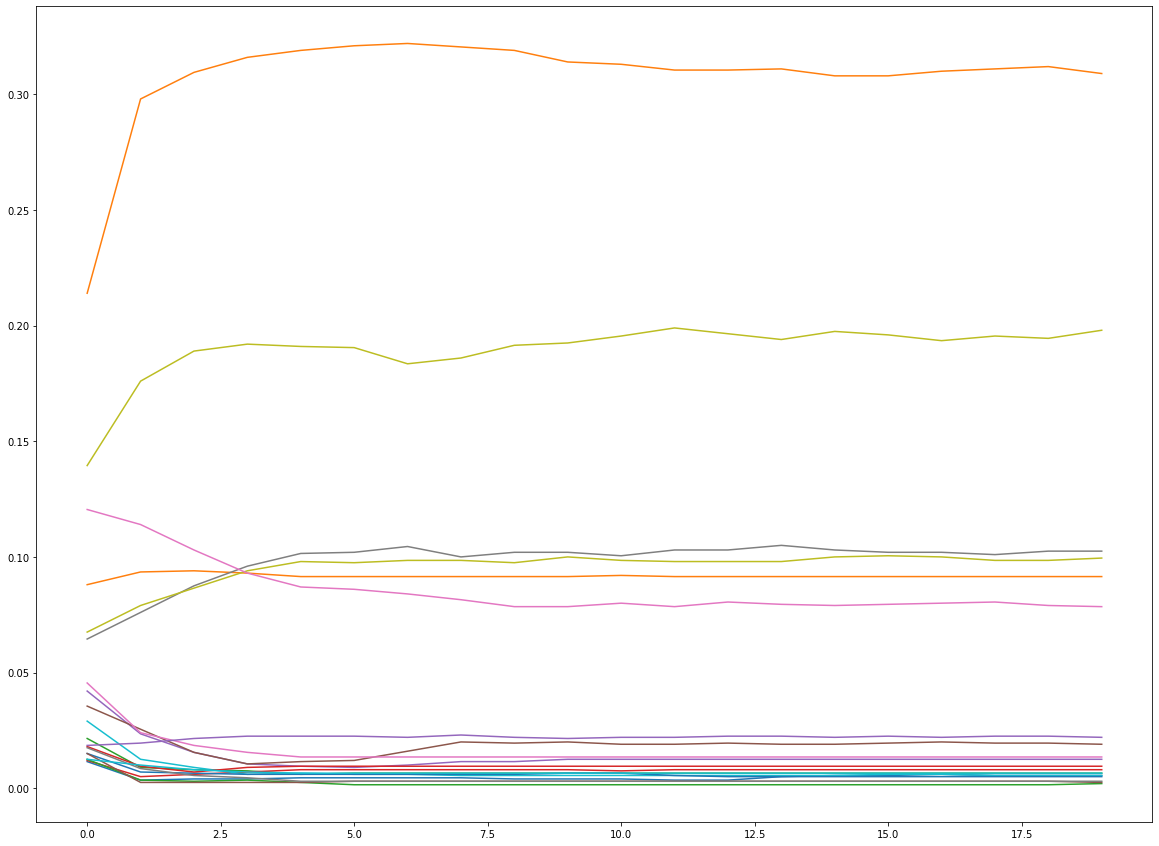

In [8]:
plt.figure(figsize=(20,15))
for i in range(20):
    plt.plot(np.arange(20),docs_mixpro[i,:])

In [9]:
lp = 0; nd = 0
for d in np.unique(B[:,0]):
    w = B[B[:,0]==d+1,1]-1
    c = B[B[:,0]==d+1,2]
    z = np.log(sk_docs.squeeze()+alpha)-np.log(np.sum(sk_docs.squeeze()+alpha))
    for k in range(K):
        b = (swk[:,k]+gamma)/(sk_words[k]+gamma*W)
        z[k] += np.dot(c,np.log(b[w]))
    lp += (np.log(np.sum(np.exp(z-z.max()))) +z.max())
    nd += np.sum(c)

perplexity = np.exp(-lp/nd)

In [10]:
I = 20
for k in range(K):
    ii = np.argsort(-swk[:,k])
    if k == 0:
        ZZ = ii[:I]
    else:
        ZZ = np.vstack((ZZ,ii[:I]))

In [11]:
for k in range(K):
    print('Group '+str(k)+':')
    tmp = []
    for i in range(I):
        tmp.append(V[ZZ[k,i]][0][0])
    print(','.join(tmp))

Group 0:
kerry,swift,boat,kerrys,star,thurlow,campaign,veterans,bush,records,bronze,john,group,general,military,aug,vietnam,elliott,war,record
Group 1:
november,poll,house,bush,senate,republicans,kerry,polls,governor,electoral,account,vote,general,democratic,voting,election,primary,democrats,war,voter
Group 2:
bunning,debate,mongiardo,gotv,kentucky,senate,senator,campaign,bunnings,oct,elections,race,republican,news,health,reporters,rumors,teleprompter,sen,monday
Group 3:
november,iraq,general,bush,war,fallujah,iraqi,house,military,poll,republicans,account,polls,governor,electoral,senate,force,kerry,saleh,petraeus
Group 4:
marriage,state,amendment,republicans,senate,vote,bush,democrats,gay,kerry,democratic,poll,republican,majority,support,hate,court,news,massachusetts,herseth
Group 5:
nader,ballot,republican,voters,general,voter,election,state,party,people,democratic,vote,ohio,republicans,registration,county,signatures,law,states,voting
Group 6:
delay,committee,house,ethics,texas,democr